# References

I referred to this blog about objection detection with mask-rcnn and applied that to this dataset about cars.
Link: https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

# Importing and Installing libraries

For my code I am using this repository that supports Tensorflow 2+.

In [1]:
!git clone https://github.com/leekunhee/Mask_RCNN.git
!cd Mask_RCNN && python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 149.27 MiB | 46.52 MiB/s, done.
Resolving deltas: 100% (572/572), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrc

In [2]:
import os,sys
import pandas as pd
import numpy as np
from os import listdir
from numpy import zeros, asarray, expand_dims, mean
from matplotlib import pyplot

ROOT_DIR = os.path.abspath("./Mask_RCNN")
sys.path.append(ROOT_DIR) 

from mrcnn.utils import Dataset,extract_bboxes
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

import warnings
warnings.filterwarnings("ignore")

# Dataset

First we will read from the csv and try to understand the format of data.

In [37]:
data = {}

In [49]:
df = {}

# for __type in ('train','valid','test'): 


df['train'] = pd.read_csv(f'/kaggle/input/dataset1/Coca-colaDetection.v1i.tensorflow/train/_annotations1.csv');

df['test'] = pd.read_csv(f'/kaggle/input/dataset1/Coca-colaDetection.v1i.tensorflow/test/_annotations.csv');

df['valid']  = pd.read_csv('/kaggle/input/dataset1/Coca-colaDetection.v1i.tensorflow/valid/_annotations.csv');

Adding_new_data("/kaggle/input/Coca-colaDetection.v1i.tensorflow/train","/kaggle/input/dataset1/Coca-colaDetection.v1i.tensorflow/train/_annotations2.csv");



722
                                            filename  width  height  \
0  Coke_055_jpg.rf.097200007b299a6b0c16e12269fef4...    480     640   
1  Coke_042_jpg.rf.0a087af68fa638d5ee654813146675...    640     480   
2  Coke_042_jpg.rf.0a087af68fa638d5ee654813146675...    640     480   
3  Coke_042_jpg.rf.0a087af68fa638d5ee654813146675...    640     480   
4  Coke_030_jpg.rf.093722ef449beca90215e64b816117...    480     640   

       class  xmin  ymin  xmax  ymax  
0  Coca-Cola    15   220   480   435  
1  Coca-Cola    37    76   225   397  
2  Coca-Cola   200    80   428   402  
3  Coca-Cola   421    91   630   404  
4  Coca-Cola     0   199   188   475  
1172


In [ ]:
import shutil
 


In [50]:
def Adding_new_data(existing_images_path_folder,new_annotation_path):
    
#     new_df = pd.read_csv(new_annotation_path);
    
    # sort it by first number
#     df['train']['sort_by'] = df['train']['filename'].str.extract(r'^(\d+)').astype(int);

#     print(df['train'].head());
    
#     # Sort the DataFrame based on the extracted part
#     df['train'] = df['train'].sort_values(by = 'sort_by');
    
#     print(df['train'].head());
    
#     last_row = df['train'].iloc[-1];

#     number_to_start = last_row['sort_by'] + 1;
    
    new_annotation_path_df = pd.read_csv(new_annotation_path);
    print(len(df['train']))
    new_annotation_path_df['class'] = 'Coca-Cola';
    print(new_annotation_path_df.head());
    df['train'] = pd.concat([df['train'],new_annotation_path_df]);
    print(len(df['train']))

        # Drop the temporary 'sort_by' column if needed
    
    # changing the 
        

In [ ]:
def change_name_fileAndMove(new_folder_path,new_data_path,old_fileName, new_fileName):
    
    for filename in os.listdir(new_data_path):

        if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):  # Adjust based on image formats you have

            old_filepath = os.path.join(new_data_path,old_fileName);

            new_filepath = os.path.join(new_data_path,new_fileName);

            # Move the file to the output directory
            shutil.move(old_filepath, new_filepath);

As you can see from above that total unique rows for image is less than total number of rows meaning we have some images repeated multiple times i.e some images have multiple cars in them. Which is why some images are repeated to give the data about their multiple bounding boxes.

In [6]:
!cp /kaggle/input/dataset/Coca-cola Detection.v1i.tensorflow/* ./

cp: cannot stat '/kaggle/input/dataset/Coca-cola': No such file or directory
cp: cannot stat 'Detection.v1i.tensorflow/*': No such file or directory


In [52]:
class CocaDataset(Dataset):
    '''
    Dataset class to load the images and their bounding boxes in the form of masks
    ''' 
    def load_dataset(self, dataset_dir='../input/dataset1/Coca-colaDetection.v1i.tensorflow', mode='train'):
        ''' 
        This function is used to load the dataset. We will only use 500 images for training the rest are for validation.
        We also have test set for which we dont have labels but are useful for visually checking 
        for how effective the training was
        '''
        self.add_class('dataset',1,'coca');

        images_dir = None
        def ___add(__row) :
#             global images_dir
            image_id = __row['filename'];
            img_path = images_dir + image_id;
            self.add_image('dataset', image_id=image_id, path=img_path);
        
        if mode == 'train':
            images_dir = dataset_dir + '/train/';
            df['train'].apply(___add,axis = 1);
        if mode == 'valid':
            images_dir = dataset_dir + '/valid/';
            df['valid'].apply(___add,axis = 1);
        if mode == 'test':
            images_dir = dataset_dir + '/test/';
            df['test'].apply(___add,axis = 1);

            
            
            
            
    def extract_boxes(self, filename):
            '''
            To get the coordinates of the bounding boxes.
            '''
            for split,dataSet in df.items():
#                 print(split)
                
                if((dataSet['filename'] == filename).any()):
                    boxes = [];
                    xmin = int(dataSet[dataSet['filename'] == filename].iloc[0,4])
                    ymin = int(dataSet[dataSet['filename'] == filename].iloc[0,5])
                    xmax = int(dataSet[dataSet['filename'] == filename].iloc[0,6])
                    ymax = int(dataSet[dataSet['filename'] == filename].iloc[0,7])
#                     print(xmin,xmax,ymin,ymax);
                    coors = [xmin, ymin, xmax, ymax];
                    boxes.append(coors)
                    
                    height =        dataSet[dataSet['filename'] == filename].iloc[0,1];
                    width =  dataSet[dataSet['filename'] == filename].iloc[0,2];
#{}                    width = 448;
#                    height = 448;
                   
                    return boxes, width, height
            
            
            
            
            
#         boxes = list()
#         xmin = int(df[bb_df['image']==filename].iloc[0,1])
#         ymin = int(bb_df[bb_df['image']==filename].iloc[0,2])
#         xmax = int(bb_df[bb_df['image']==filename].iloc[0,3])
#         ymax = int(bb_df[bb_df['image']==filename].iloc[0,4])
#         coors = [xmin, ymin, xmax, ymax]
#         boxes.append(coors)
#         width = 380
#         height = 676
#         return boxes, width, height
    
    def load_mask(self, image_id):
        '''
        Takes the co-ordinates and uses that to make it into a mask.
        '''
        info = self.image_info[image_id];
#         print(info);
        file = info['id'];
#         print(file);
        boxes, w, h = self.extract_boxes(file);
#         print(w,h);
        masks = zeros([w, h, len(boxes)], dtype='uint8')
        
        
#         print(masks);
        class_ids = list();
        
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('coca'));
            
          
        return masks, asarray(class_ids, dtype='int32')


In [53]:
#Loading all the datasets we will need.
train_set = CocaDataset()
train_set.load_dataset(mode='train')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

val_set = CocaDataset()
val_set.load_dataset(mode='valid')
val_set.prepare()
print('Validate: %d' % len(val_set.image_ids))
 
test_set = CocaDataset()
test_set.load_dataset(mode='test')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 1172
Validate: 144
Test: 71


Here we will visualise some of the images from the dataset along side their masks.

In [54]:
def plot(num_img=5):
    for i in range(num_img):
        image_id = np.random.randint(0,len(train_set.image_ids))
        image = train_set.load_image(image_id)
        mask, class_ids = train_set.load_mask(image_id)
        pyplot.imshow(image)
        pyplot.imshow(mask[:, :, 0], cmap='gray', alpha=0.3)
        pyplot.show()

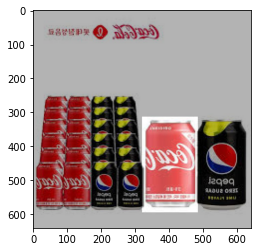

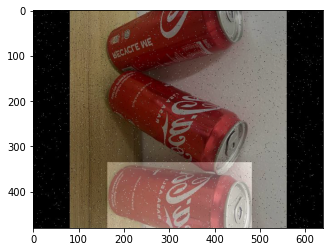

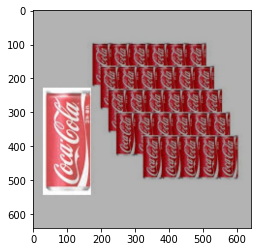

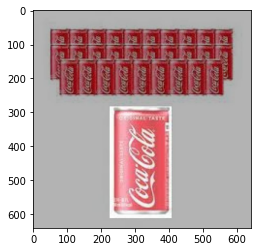

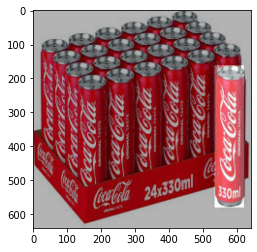

In [55]:
plot()

# Training

This config file contains a lot of important parameters for model training.

In [56]:

class CarsConfig(Config):
    NAME = "cars_cfg"
    NUM_CLASSES = 2 #Bckground is counted as class too so background + cars = 2 labels
    STEPS_PER_EPOCH = 200
    VALIDATION_STEPS = 20
    IMAGES_PER_GPU = 1
    IMAGE_MIN_DIM = 320
    IMAGE_MAX_DIM = 512
    
config = CarsConfig()

In [ ]:
!ls -lls /kaggle/working

In [57]:
config.display() #list of all available configurations


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [58]:
model = MaskRCNN(mode='training', model_dir='./', config=config);

We are going to load pre-trained weights for this task. This will save us a lot of time because these algorithms can take a lot of time to converge

In [59]:
model.load_weights('../input/mask-rcnn-coco-weights/mask_rcnn_coco.h5', by_name=True
                   , exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]
                  )
# model.load_weights('./'+path+'/mask_rcnn_cars_cfg_0030.h5', by_name=True );
#                    , exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]
                  
# './'+path+'/mask_rcnn_cars_cfg_0030.h5'

# model.train(train_set , val_set , learning_rate=config.LEARNING_RATE, epochs = 30, layers='all');

# Evaluation

We need to define a seperate config file for predictions purposes.

In [62]:
!ls -lls /kaggle/working/

total 8
4 drwxr-xr-x 10 root root 4096 Apr 16 11:01 Mask_RCNN
4 drwxr-xr-x  3 root root 4096 Apr 16 12:52 cars_cfg20240416T1159


In [63]:
class PredictionConfig(Config):
    NAME = "cars_cfg"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    USE_MINI_MASK = False

In [64]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)

Loading the saved weights to perform inference.

In [116]:
for i in listdir():
    if i[:4] =='cars':
        path=i
model.load_weights('./'+path+'/mask_rcnn_cars_cfg_0010.h5', by_name=True)

Re-starting from epoch 10


In [66]:
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)
        r = yhat[0]
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    mAP = mean(APs)
    return mAP

In [ ]:
# model.save_weights('weights',save_format = 'tf');

In [73]:
# train_mAP = evaluate_model(train_set, model, cfg)
# print("Train mAP: %.3f" % train_mAP)
val_mAP = evaluate_model(val_set, model, cfg)
print("Validation mAP: %.3f" % val_mAP)

Validation mAP: 0.757


# Actual vs Predicted

Fianlly we will compare our model preformances by simply seeing how well it is detecting cars compared to the real bounding boxes.

In [140]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=10):
    for i in range(n_images):
        id = np.random.randint(0,len(dataset.image_ids))
        pyplot.figure(figsize=(50, 50))
        image = dataset.load_image(id)
        mask, _ = dataset.load_mask(id)
        scaled_image = mold_image(image, cfg)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)[0]
        pyplot.subplot(n_images, 2, i*2+1)
        pyplot.imshow(image)
        pyplot.title('Actual')
        for j in range(mask.shape[2]):
            pyplot.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        pyplot.subplot(n_images, 2, i*2+2)
        pyplot.imshow(image)
        pyplot.title('Predicted')
        ax = pyplot.gca()
        for box in yhat['rois']:
            y1, x1, y2, x2 = box
            width, height = x2 - x1, y2 - y1
            rect = Rectangle((x1, y1), width, height, fill=True, color='green',alpha=0.5)
            ax.add_patch(rect)
    pyplot.show()

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_actual_vs_predicted_one(image, model, cfg):
    scaled_image = mold_image(image, cfg)
    sample = expand_dims(scaled_image, 0)
    yhat = model.detect(sample, verbose=0)[0]

    plt.figure(figsize=(12, 6))

    # Plot actual (assuming there's no ground truth information provided)
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Actual')

    # Plot predicted
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.title('Predicted')
    ax = plt.gca()
    for box in yhat['rois']:
        y1, x1, y2, x2 = box
        print()
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=True, color='green', alpha=0.5)
        ax.add_patch(rect)

    plt.show()

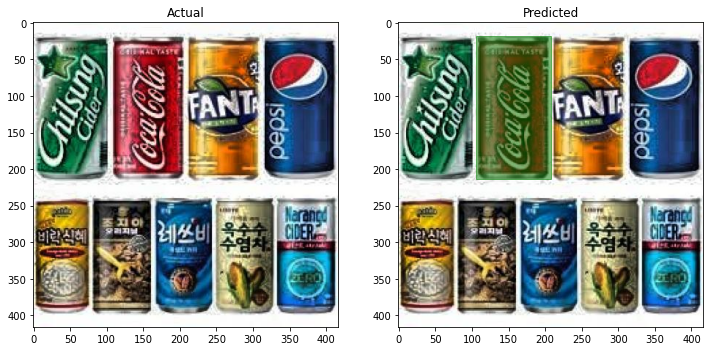

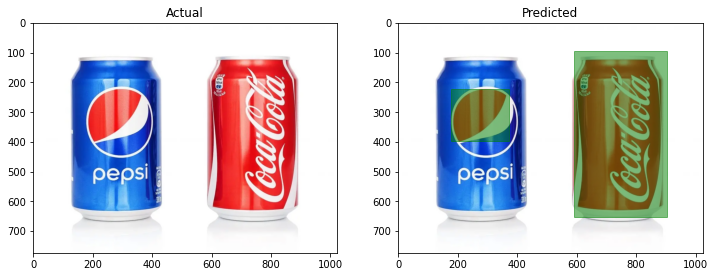

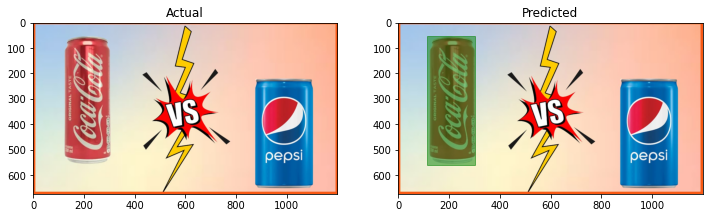

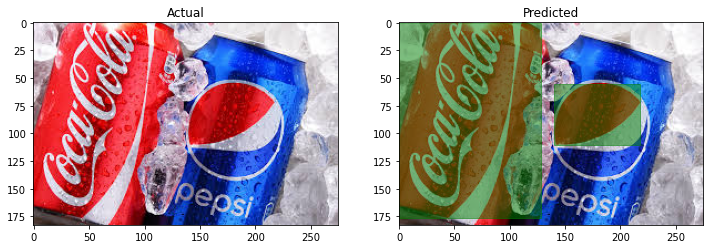

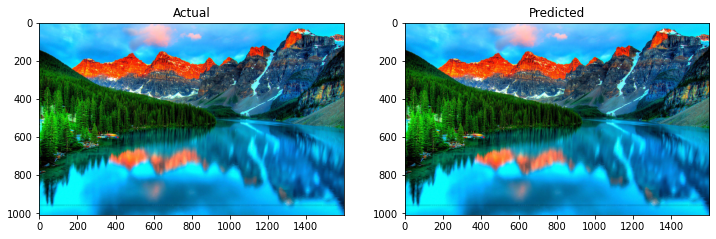

In [139]:
import matplotlib.pyplot as plt
import cv2 




import cv2
import numpy as np
import matplotlib.pyplot as plt

def import__matrix(image_path): 
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load and plot each image
image_paths = [
    "/kaggle/input/ai24-day/test/327_jpg.rf.35354ed7427e4c060952ba06019c96fa.jpg",
    "/kaggle/input/test-test/coke-vs-pepsi-1-1024x774.webp",
    "/kaggle/input/test-hkgjgjhygj/Evolution-of-Indian-Banking-startuptalky--4-.jpg",
    "/kaggle/input/tets-an-other-test/images.jpeg" ,
    "/kaggle/input/nature-wallpaper/3-nature-wallpaper-mountain.jpg"
]

for image_path in image_paths:
    plot_actual_vs_predicted_one(import__matrix(image_path), model, cfg)


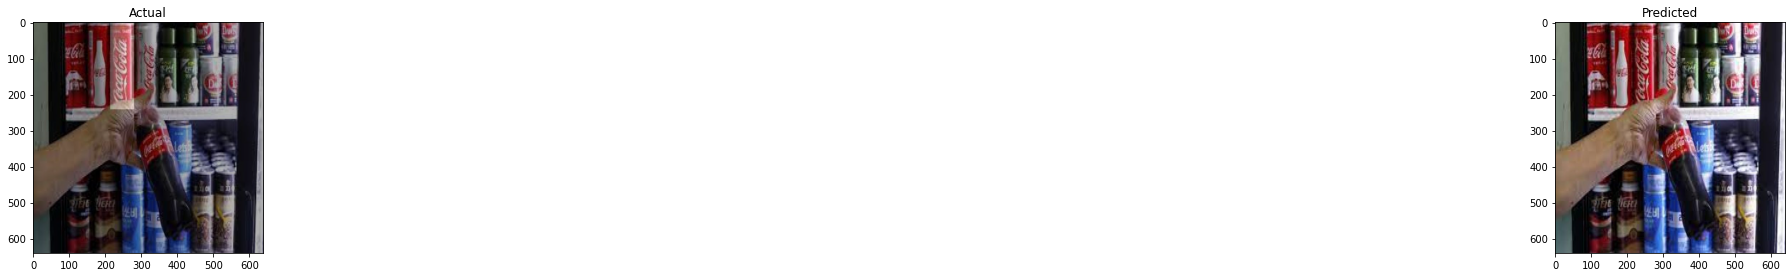

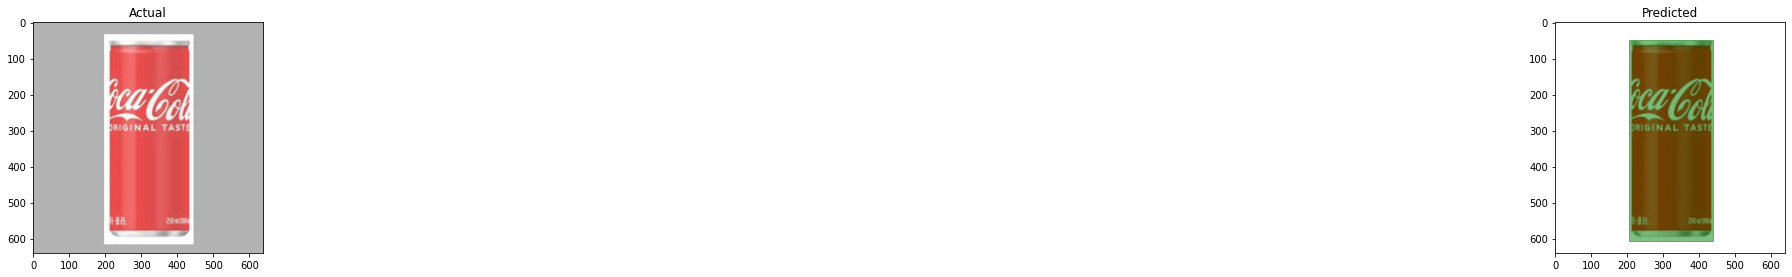

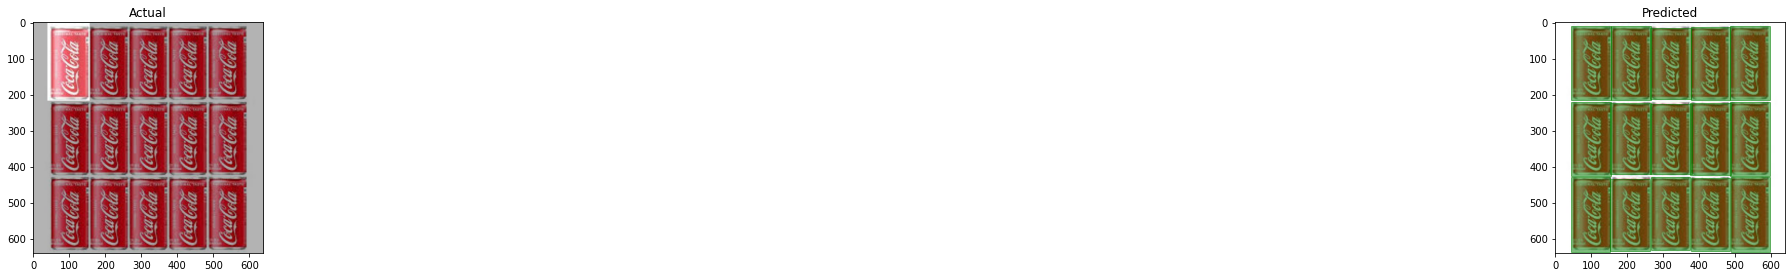

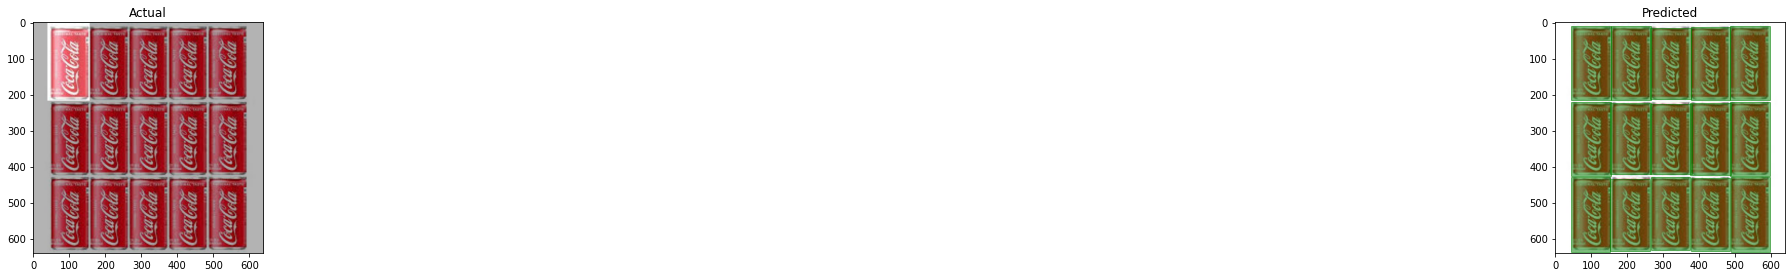

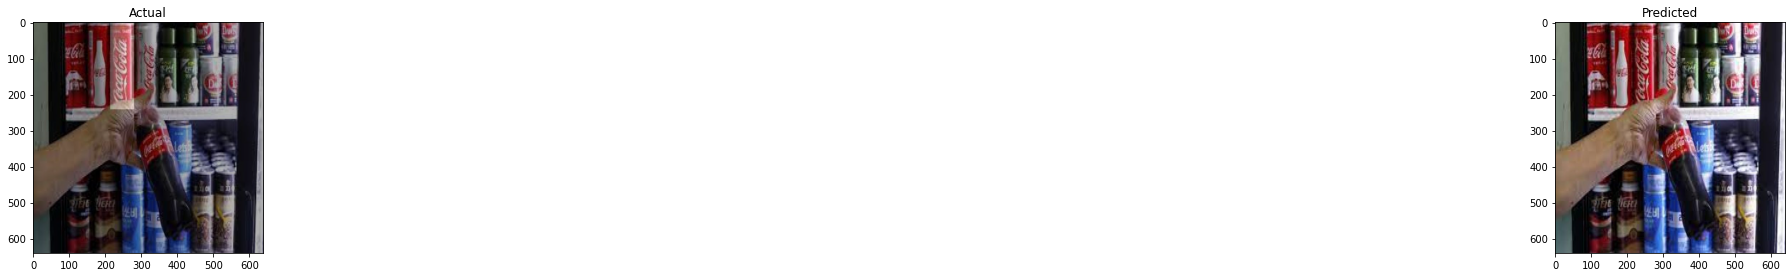

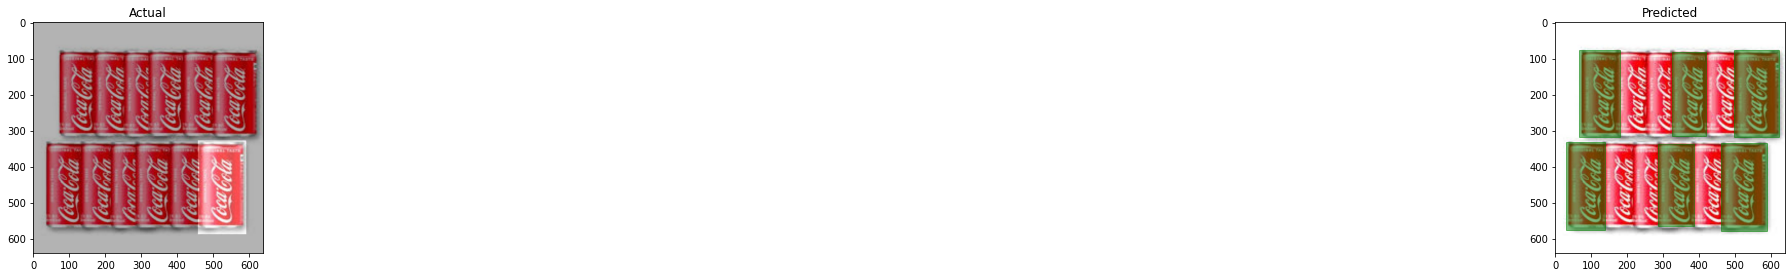

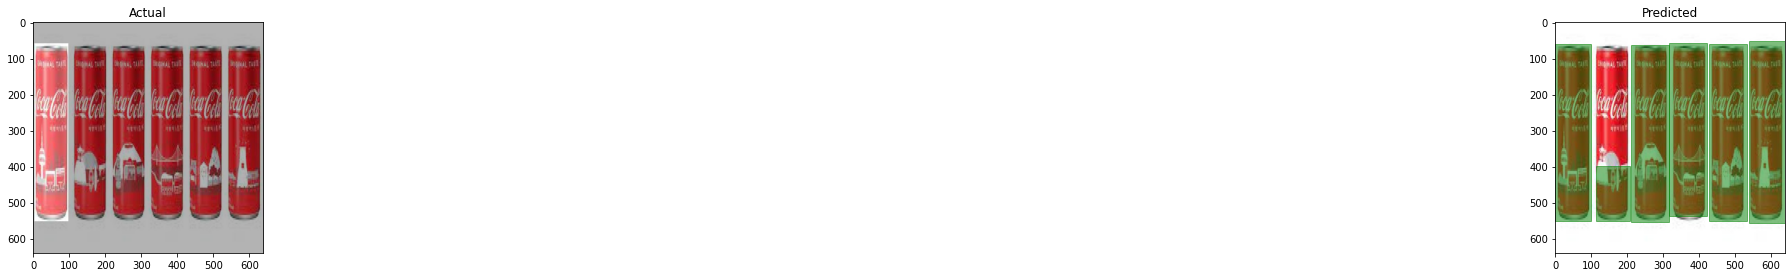

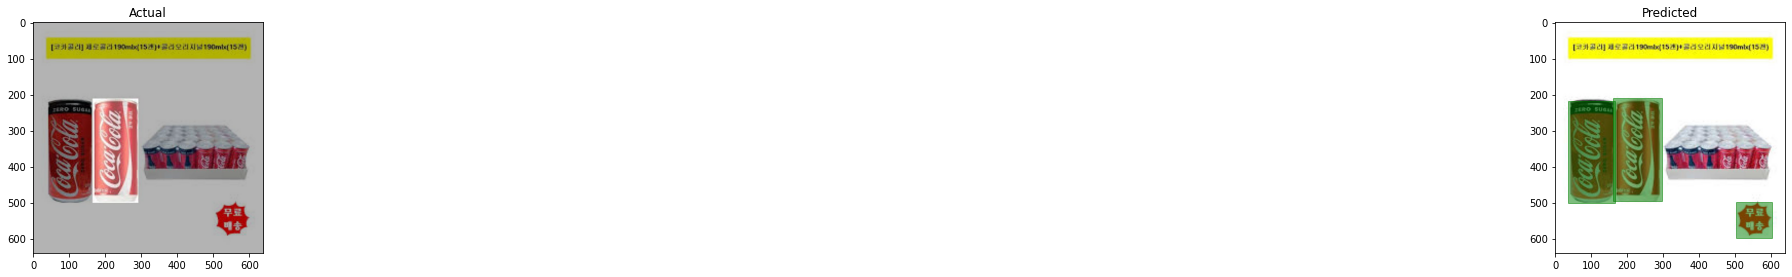

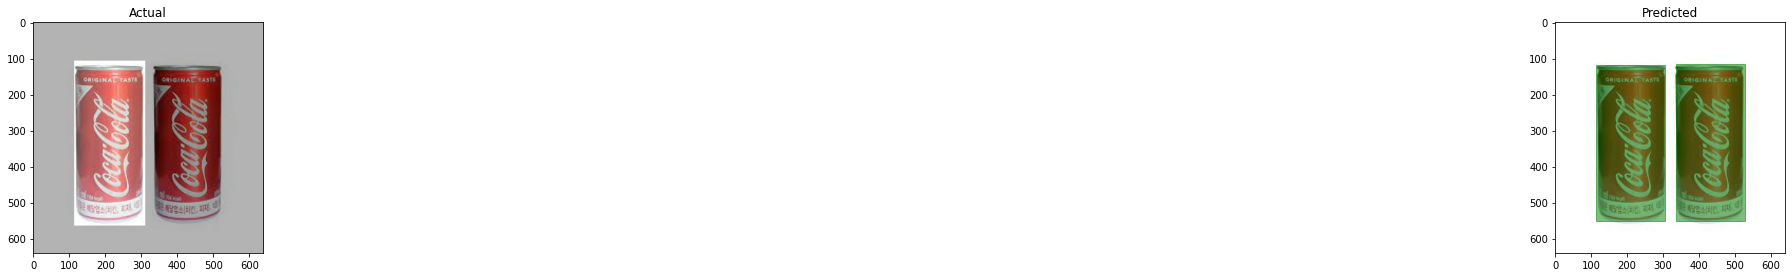

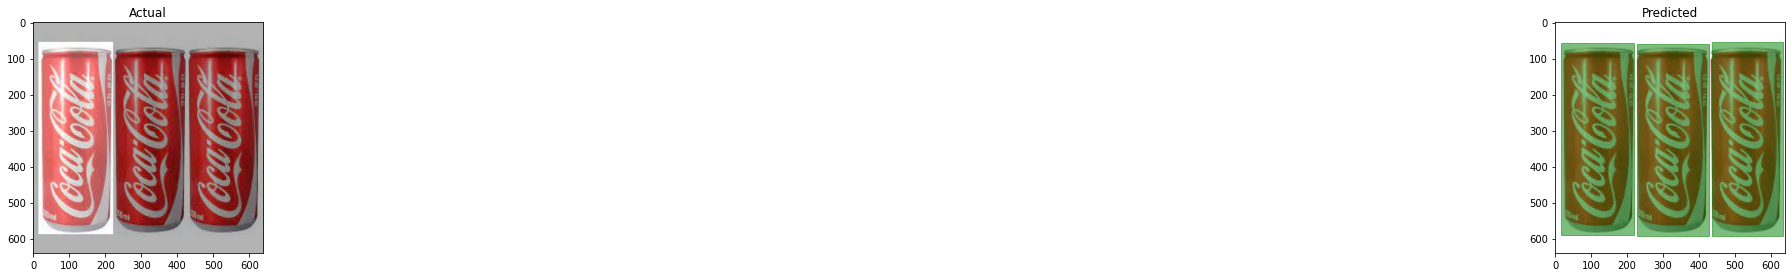

In [141]:
from matplotlib.patches import Rectangle;
plot_actual_vs_predicted(test_set, model, cfg);